In [2]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from oneibl.onelight import ONE # only used for downloading data
# import wget
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1

ibl_data_path = '../data_IBL'
myColors = ['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']
myFeatures = ['bias','contrast left','contrast right', 'previous choice', 'previous reward']

sns.set_context("talk")



In [2]:
# Downloading data, then unzipping manually in folder, then preprocessing with below code from Psytrack notebook

# current_cwd = os.getcwd()
# SPATH = current_cwd + "/Figures"
# ibl_data_path = SPATH + '/ibl-behavioral-data-Dec2019'
# # os.chdir(ibl_data_path)
# # print(os.getcwd())

# # import subprocess

# # def runcmd(cmd, verbose = False, *args, **kwargs):

# #     process = subprocess.Popen(
# #         cmd,
# #         stdout = subprocess.PIPE,
# #         stderr = subprocess.PIPE,
# #         text = True,
# #         shell = True
# #     )
# #     std_out, std_err = process.communicate()
# #     if verbose:
# #         print(std_out.strip(), std_err)
# #     pass

# # runcmd('echo "Hello, World!"', verbose = True)

# # runcmd("wget https://ndownloader.figshare.com/files/21623715", verbose = True)

# # Search all sessions that have these dataset types.
# required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
#                  '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
# one = ONE()
# eids = one.search(required_vars)

# mouseData = pd.DataFrame()
# for eid in eids:
#     lab, _, subject, date, session = eid.split("/")    
#     sess_vars = {
#         "eid": eid,
#         "lab": lab,
#         "subject": subject,
#         "date": date,
#         "session": session,
#     }
#     mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)

# all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
# df = pd.DataFrame()

# all_mice = []
# for j, s in enumerate(mouseData["subject"].unique()):
#     print("\rProcessing " + str(j+1) + " of " + str(len(mouseData["subject"].unique())), end="")
#     mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
#     for i, row in mouse.iterrows():
#         myVars = {}
#         for v in all_vars:
#             filename = "_ibl_trials." + v + ".npy"
#             var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
#             myVars[v] = list(np.load(var_file).flatten())

#         num_trials = len(myVars[v])
#         myVars['lab'] = [row.lab]*num_trials
#         myVars['subject'] = [row.subject]*num_trials
#         myVars['date'] = [row.date]*num_trials
#         myVars['session'] = [row.session]*num_trials

#         all_mice += [pd.DataFrame(myVars, columns=myVars.keys())]
        
# df = pd.concat(all_mice, ignore_index=True)

# df = df[df['choice'] != 0]        # dump mistrials
# df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit
# df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
# df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
# df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
# df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct
# df["correctSide"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
# df.loc[df["correctSide"]==1, "correctSide"] = 0
# df.loc[df["correctSide"]==-1, "correctSide"] = 1
# df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
# df.loc[df["choice"]==1, "choice"] = 0
# df.loc[df["choice"]==-1, "choice"] = 1
# df.to_csv(SPATH+"ibl_processed.csv", index=False)

In [3]:
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
dfAll.head()

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,correctSide
0,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
1,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
2,0.0,1.0,1,1,1.0,angelakilab,IBL-T1,2019-02-09,1,1
3,0.5,0.0,0,1,0.5,angelakilab,IBL-T1,2019-02-09,1,0
4,0.5,0.0,0,1,0.9,angelakilab,IBL-T1,2019-02-09,1,0


In [4]:
data = dfAll[dfAll['subject']=='ibl_witten_15']
print(data['probabilityLeft'])

3327480    0.5
3327481    0.5
3327482    0.9
3327483    0.5
3327484    0.8
          ... 
3397128    0.8
3397129    0.8
3397130    0.8
3397131    0.8
3397132    0.8
Name: probabilityLeft, Length: 69653, dtype: float64


In [8]:
print("contrastLeft: ", np.unique(dfAll['contrastLeft']))   # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("contrastRight: ", np.unique(dfAll['contrastRight'])) # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("choice: ", np.unique(dfAll['choice']))               # [0, 1]
print("feedbackType: ", np.unique(dfAll['feedbackType']))   # [0, 1]
print("correctSide: ", np.unique(dfAll['correctSide']))               # [0, 1]
print("lab: ", np.unique(dfAll['lab']))

contrastLeft:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
contrastRight:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
choice:  [0 1]
feedbackType:  [0 1]
correctSide:  [0 1]
lab:  ['angelakilab' 'churchlandlab' 'cortexlab' 'danlab' 'hoferlab' 'mainenlab'
 'mrsicflogellab' 'wittenlab' 'zadorlab']


In [4]:
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


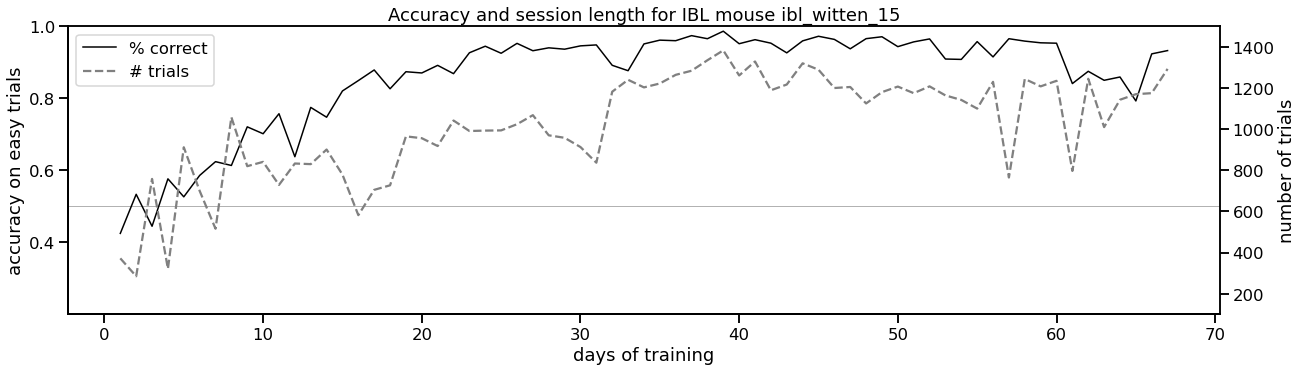

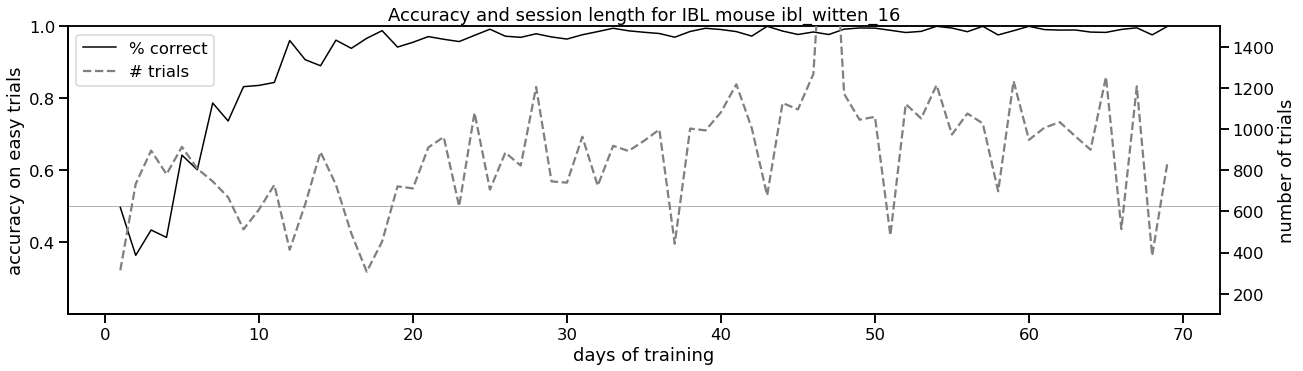

In [5]:
for subject in ['ibl_witten_15','ibl_witten_16']: #subjectsWitten: 
    fig = plt.figure(figsize=(16,4))
    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    axes = [ax1,ax2]
    IBL_plot_performance(dfAll, subject=subject, axes=axes, sessStop=-1)


# Fitting K=1,2,3 dGLM-HMM1 with CV for folds=4 until session sessStop=40

In [13]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2
D = 3

# last session to use in fitting
sessStop = 40

In [7]:
# fitting for K = 1,2,3

for K in [1,2,3]:
    for subject in ['ibl_witten_15','ibl_witten_16']:
        x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=3) # NOT LOOKING AT FULL DATASET
        print(x.shape)

        glmhmmW = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')
        glmhmmP = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')

        # fitting
        trainLl, testLl, allP, allW, trainSessInd, testSessInd = fit_eval_CV_multiple_sigmas(x, y, sessInd, K, splitFolds=splitFolds, fitFolds=fitFolds, sigmaList=sigmaList, maxiter=maxiter, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=L2penaltyW, priorDirP=priorDirP)
        
        # saving
        for fold in range(0, fitFolds):
            np.save(f'../data_IBL/trainLl_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', trainLl[fold])
            np.save(f'../data_IBL/testLl_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', testLl[fold])
            np.save(f'../data_IBL/P_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', allP[fold])
            np.save(f'../data_IBL/W_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', allW[fold])
            np.save(f'../data_IBL/trainSessInd_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', np.array(trainSessInd[fold]))
            np.save(f'../data_IBL/testSessInd_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', np.array(testSessInd[fold]))


(36672,)
36672
(36672, 3)
Fold 0 training size 27382
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
100
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 27512
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
100
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
(30716,)
30716
(30716, 3)
Fold 0 training size 22886
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 23038
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
20

# Fitting K=1,2,3 dGLM-HMM1 with for folds=4 until sessStop=-1 (all data)

In [10]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2

# last session to use in fitting
sessStop = -1

In [15]:
# fitting for K = 1,2,3
for K in [1,2,3]:
    for subject in ['ibl_witten_15','ibl_witten_16']:
        x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop) # NOT LOOKING AT FULL DATASET
        print(x.shape)

        glmhmmW = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')
        glmhmmP = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')

        # fitting
        trainLl, testLl, allP, allW, trainSessInd, testSessInd = fit_eval_CV_multiple_sigmas(x, y, sessInd, K, splitFolds=splitFolds, fitFolds=fitFolds, sigmaList=sigmaList, maxiter=maxiter, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=L2penaltyW, priorDirP=priorDirP)
        
        # saving
        for fold in range(0, fitFolds):
            np.save(f'../data_IBL/trainLl_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', trainLl[fold])
            np.save(f'../data_IBL/testLl_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', testLl[fold])
            np.save(f'../data_IBL/P_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', allP[fold])
            np.save(f'../data_IBL/W_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', allW[fold])
            np.save(f'../data_IBL/trainSessInd_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', np.array(trainSessInd[fold]))
            np.save(f'../data_IBL/testSessInd_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', np.array(testSessInd[fold]))


(60802,)
60802
(60802, 3)
Fold 0 training size 45326
Sigma Index 0
0
Sigma Index 1
0
Sigma Index 2
0
Sigma Index 3
0
Sigma Index 4
0
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 45615
Sigma Index 0
0
Sigma Index 1
0
Sigma Index 2
0
Sigma Index 3
0
Sigma Index 4
0
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
(68237,)
68237
(68237, 3)
Fold 0 training size 50905
Sigma Index 0
0
Sigma Index 1
0
Sigma Index 2
0
Sigma Index 3
0
Sigma Index 4
0
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 51234
Sigma Index 0
0
Sigma Index 1
0
Sigma Index 2
0
Sigma Index 3
0
Sigma Index 4
0
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0


# Looking at model performance and parameters

In [52]:
# Reading models for following hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2

# to tweak for different models:
sessStop = 40 # sessStop in [40,-1]
subject = 'ibl_witten_16' # subject in ['ibl_witten_15','ibl_witten_16']

testLl = []
allP = [] 
allW = [] 
trainSessInd = []
for K in range(1,4):
    for fold in range(0, fitFolds):
        testLl.append(np.load(f'../data_IBL/testLl_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        allP.append(np.load(f'../data_IBL/P_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        allW.append(np.load(f'../data_IBL/W_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        trainSessInd.append(np.load(f'../data_IBL/trainSessInd_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))

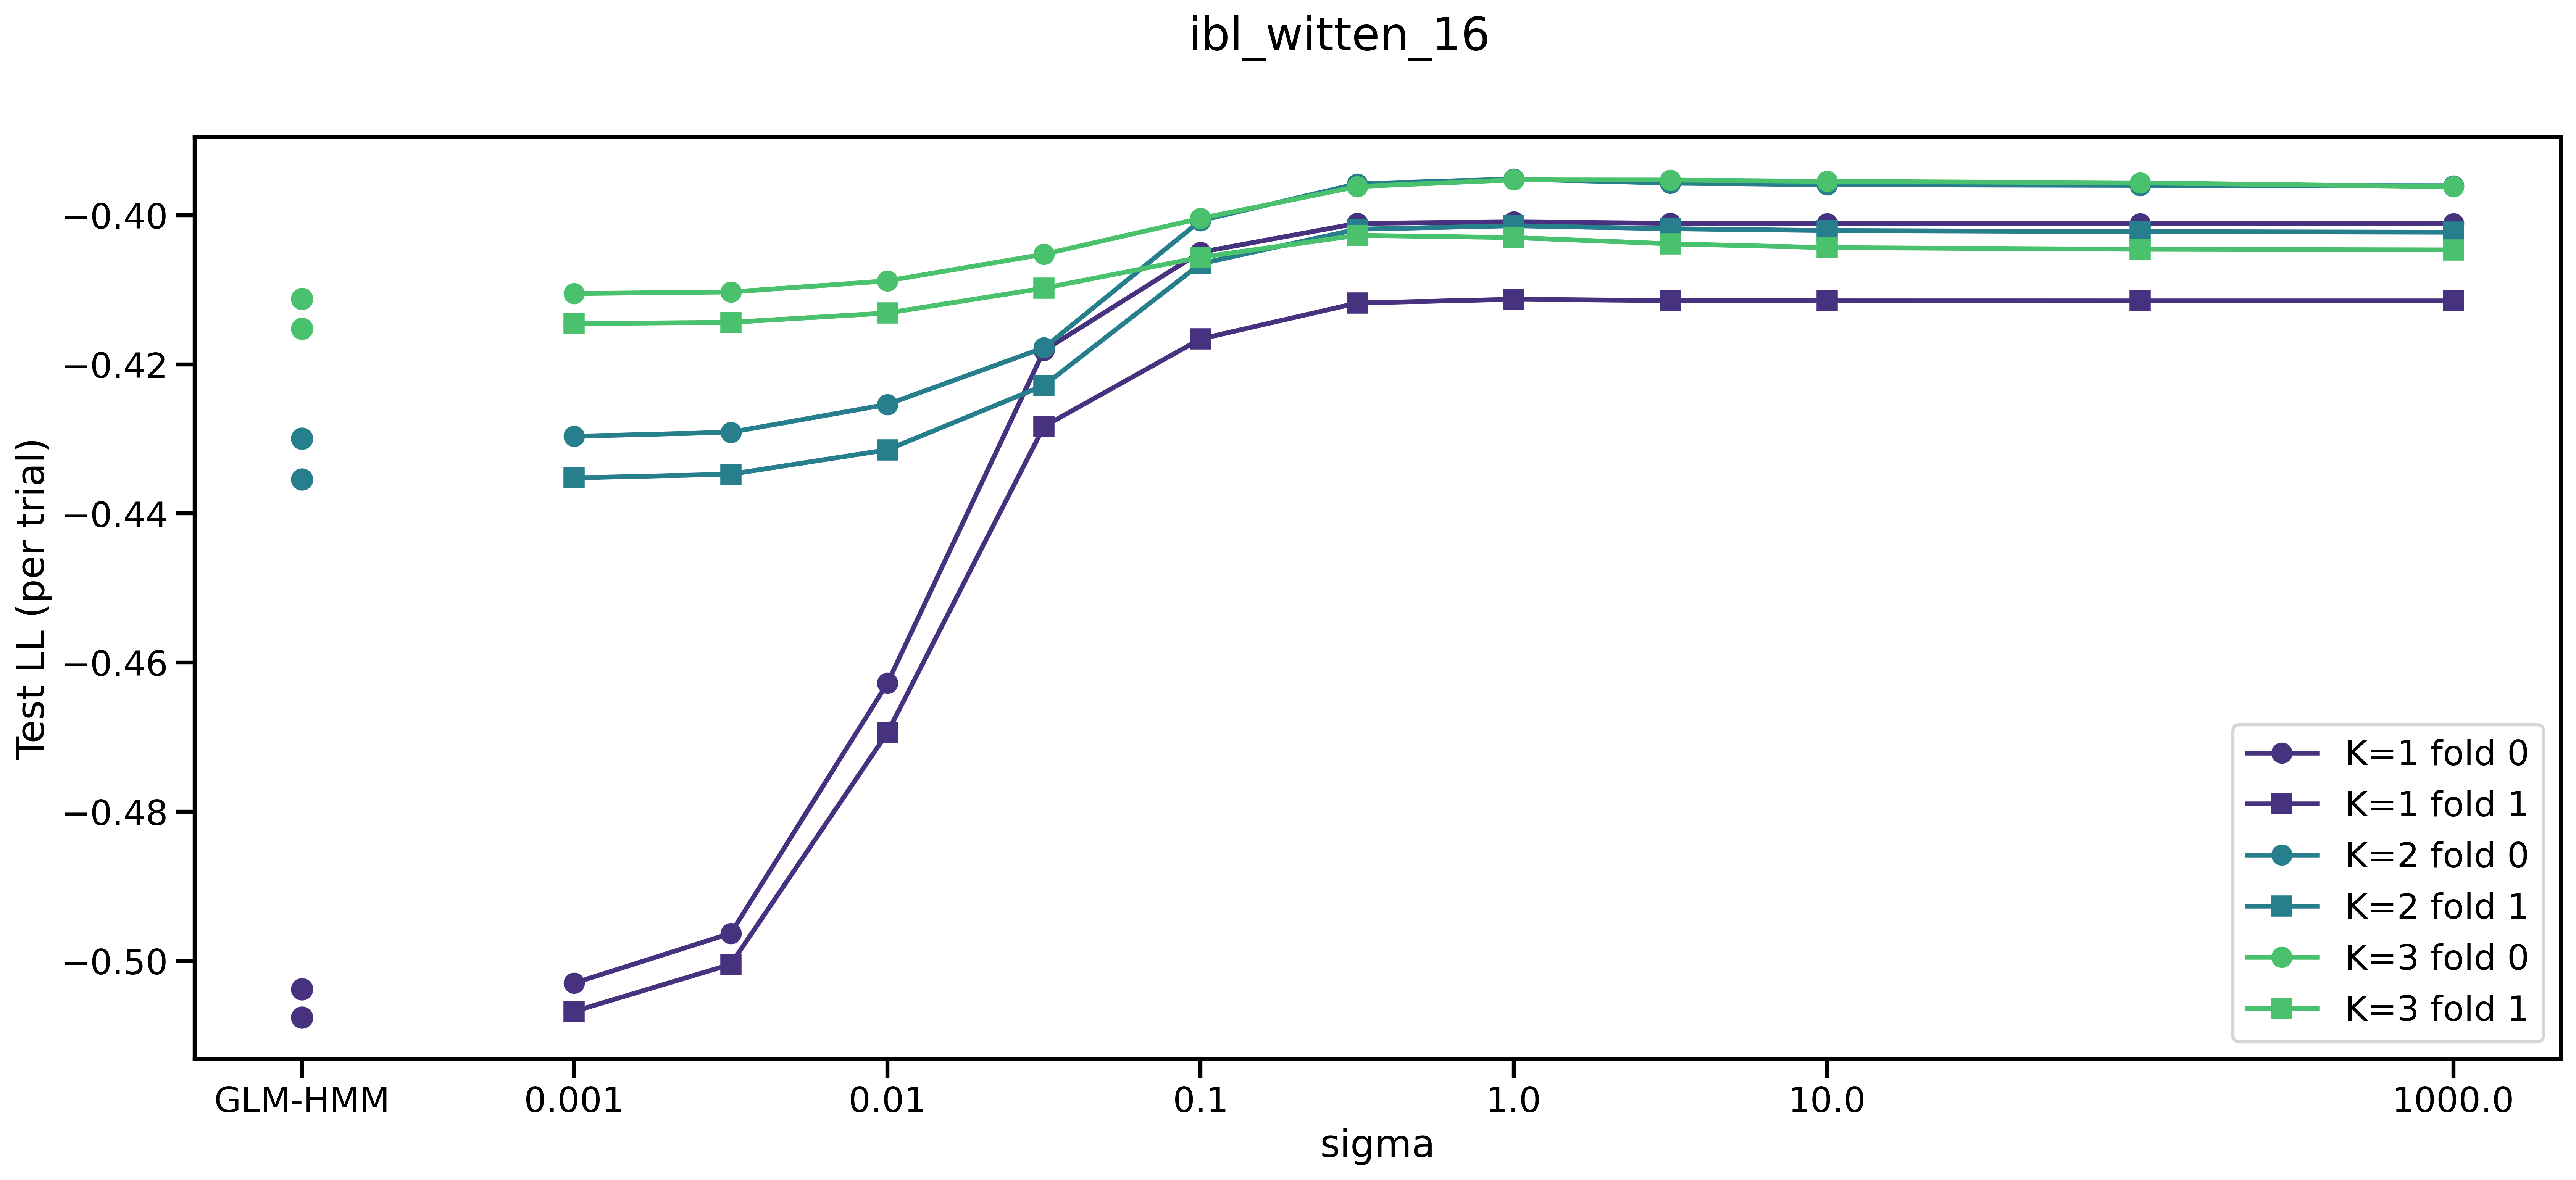

In [53]:
ls = ['-o','-s']
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject}')
for K in range(1,4):
    for fold in range(0, fitFolds):
        plot_testLl_CV_sigma(testLl[fitFolds*(K-1)+fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=2*(K-1), axes=axes, linestyle=ls[fold])

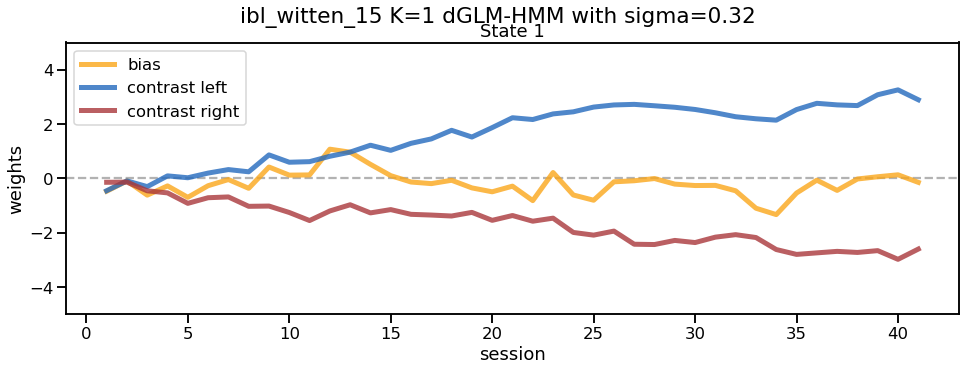

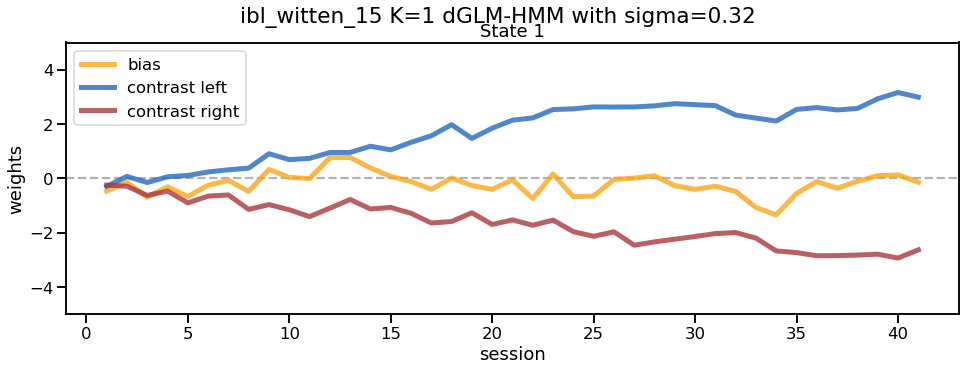

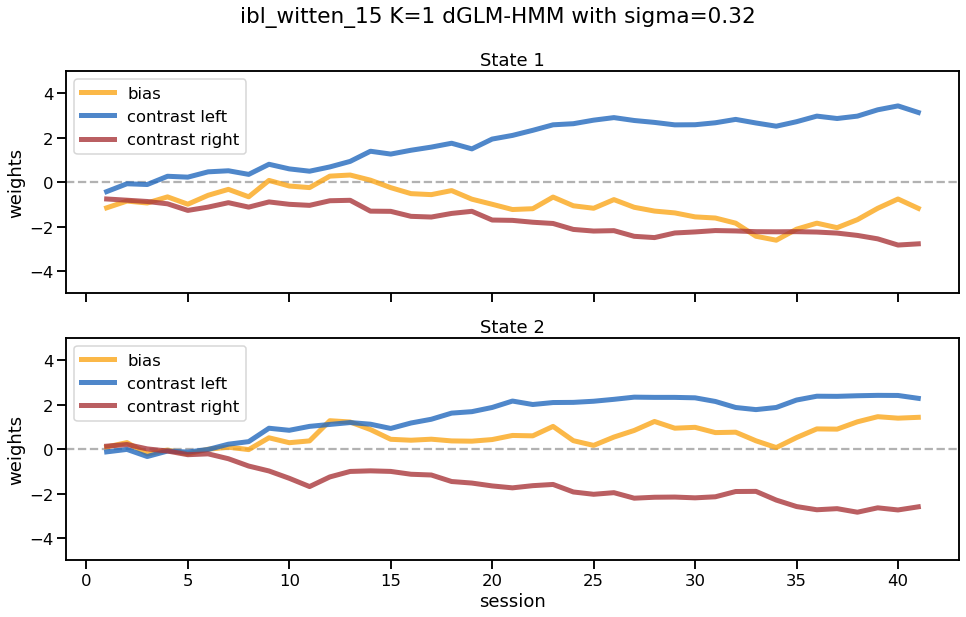

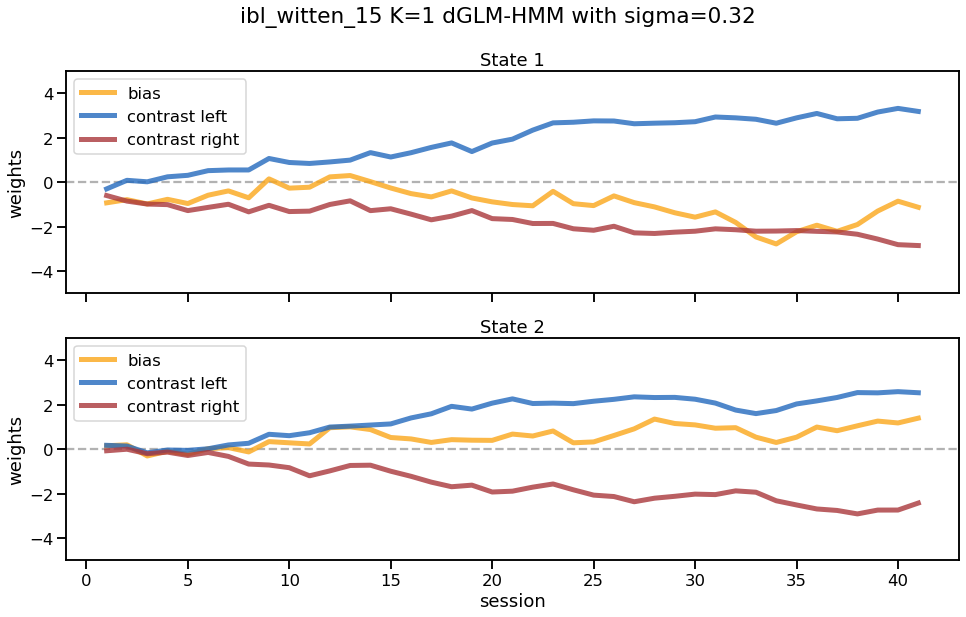

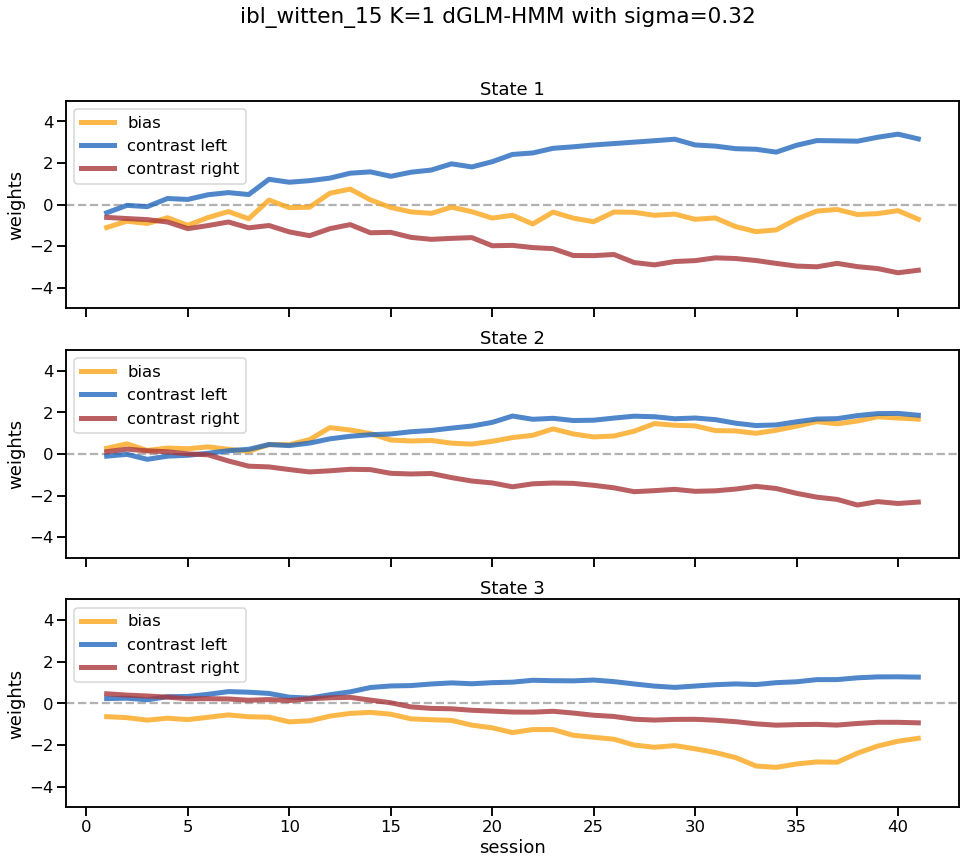

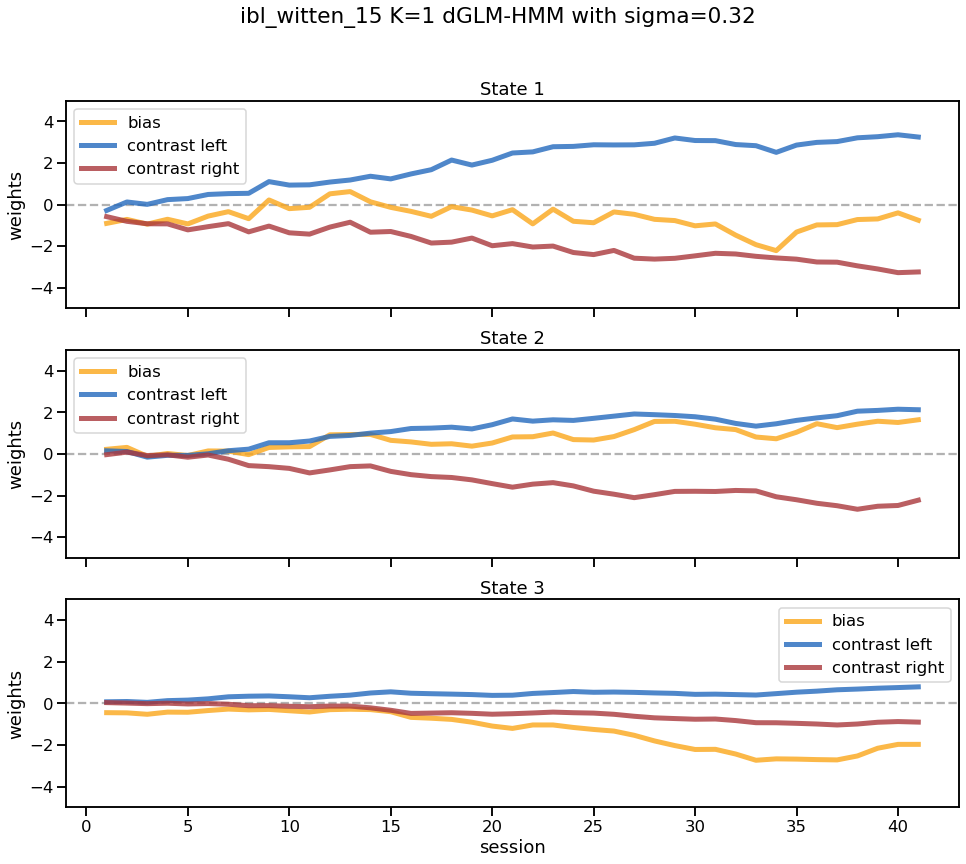

In [8]:
ind = 6
for K in range(1,4):
    for fold in range(0, fitFolds):
        fig, axes = plt.subplots(K, 1,figsize=(16,4*K+1), sharex=True)
        fig.suptitle(f'{subject} K=1 dGLM-HMM with sigma={np.round(sigmaList[ind],2)}')
        # fig.tight_layout()
        plotting_weights_IBL(allW[2*(K-1)+fold][ind], trainSessInd[2*(K-1)+fold], axes, yLim=[-5,5], colors=myColors, labels=myFeatures)

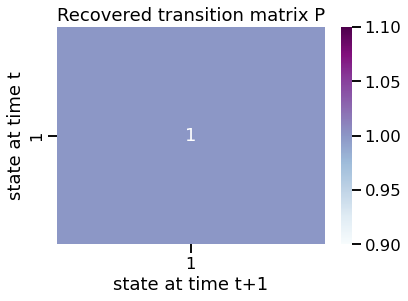

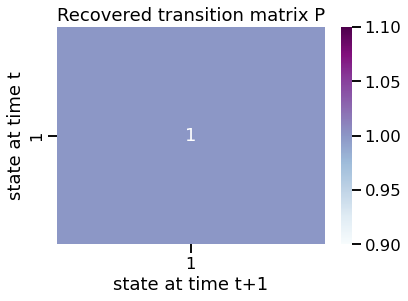

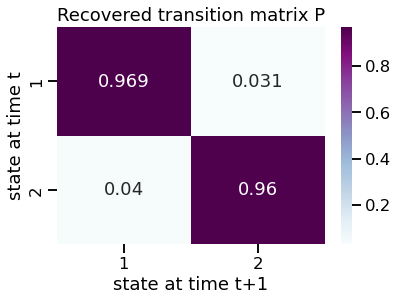

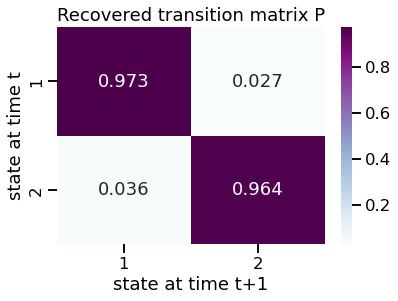

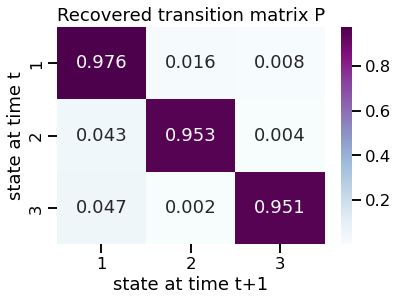

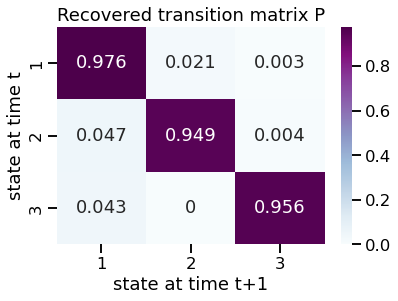

In [9]:
ind = 6
for K in range(1,4):
    for fold in range(0, fitFolds):
        fig, axes = plt.subplots()
        sortedStateInd = get_states_order(allW[2*(K-1)+fold][ind], trainSessInd[0])
        plot_transition_matrix(allP[2*(K-1)+fold][ind], sortedStateInd)

### Averaging across folds the testLL

In [11]:
# Reading models for following hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2

# to tweak for different models:
sessStop = 40 # sessStop in [40,-1]
subject = 'ibl_witten_16' # subject in ['ibl_witten_15','ibl_witten_16']

avgTestLl = []
allP = [] 
allW = [] 
trainSessInd = []
for K in range(1,4):
    testLl = []
    for fold in range(0, fitFolds):
        testLl.append(np.load(f'../data_IBL/testLl_{subject}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    avgTestLl.append(np.mean(testLl[:],axis=0))

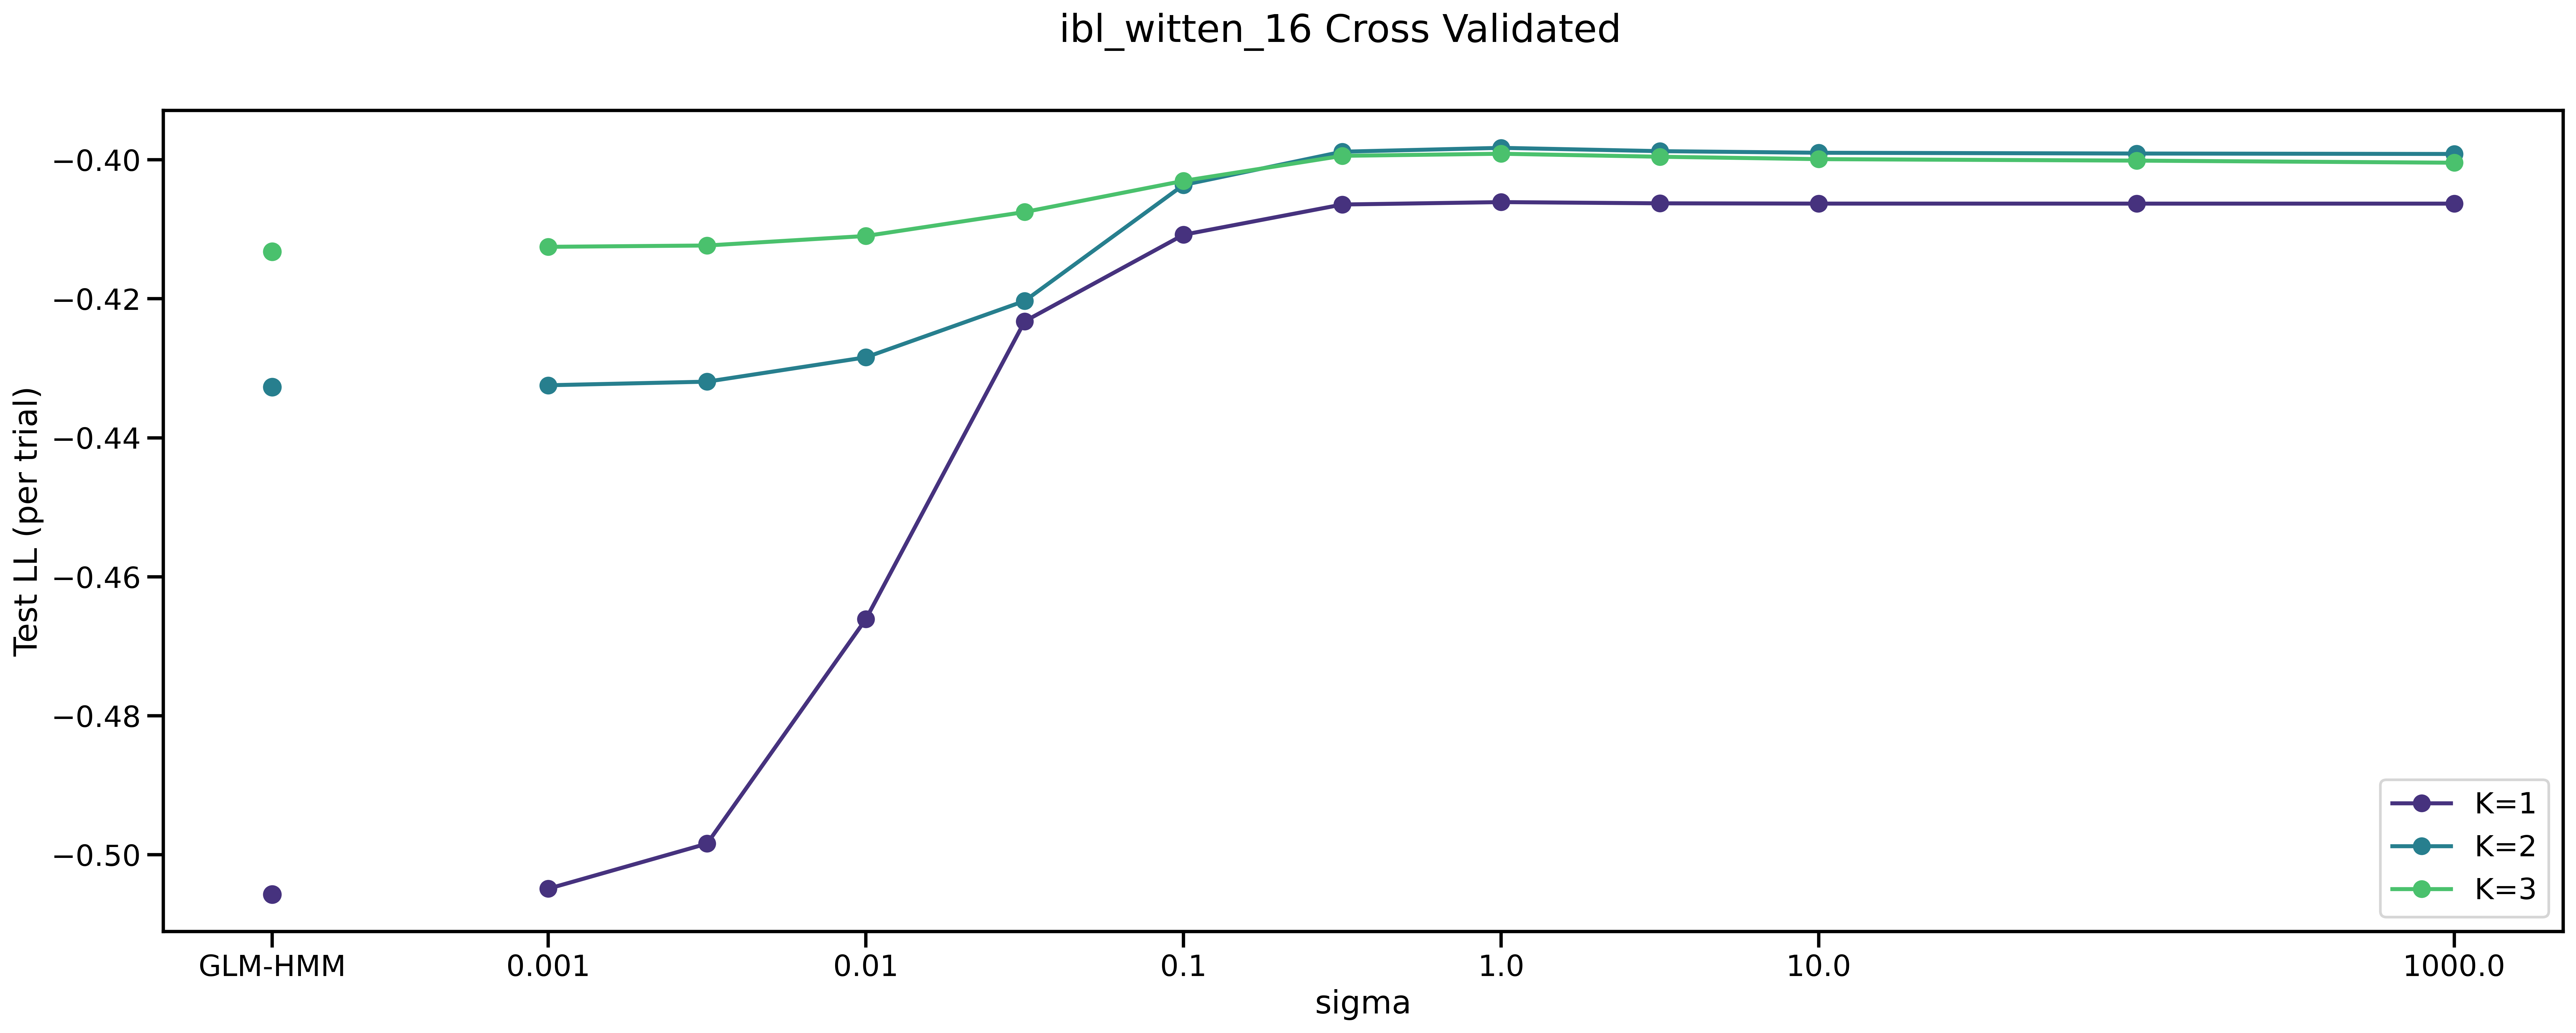

In [57]:
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject} Cross Validated')
fig.tight_layout()
for K in range(1,4):
    plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=2*(K-1), axes=axes)

In [61]:
ind = 6
K = 2
fold = 0

sessStop = 40
x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=3) # NOT LOOKING AT FULL DATASET
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=splitFolds, blocks=10, random_state=1)
N = trainX[fold].shape[0]
D = trainX[fold].shape[1]
C = 2


dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
gamma = dGLM_HMM.get_posterior_latent(allP[2*(K-1)+fold][ind], allW[2*(K-1)+fold][ind], trainX[fold], trainY[fold], trainSessInd[fold], pi0=None)

plot_posteior_latent(gamma, trainSessInd[0], sessions = [5,22,34])


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts


# Fitting full models with D=5 (previous choice and previous reward added)

In [4]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2
D = 5

# last session to use in fitting
sessStop = 40

In [6]:
# fitting for K = 1,2,3
for K in [1,2,3]:
    for subject in ['ibl_witten_15']:
        x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
        print(x.shape)

        glmhmmW = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state.npy')
        glmhmmP = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state.npy')

        # fitting
        trainLl, testLl, allP, allW, trainSessInd, testSessInd = fit_eval_CV_multiple_sigmas(x, y, sessInd, K, splitFolds=splitFolds, fitFolds=fitFolds, sigmaList=sigmaList, maxiter=maxiter, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=L2penaltyW, priorDirP=priorDirP)
        
        # saving
        for fold in range(0, fitFolds):
            np.save(f'../data_IBL/trainLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', trainLl[fold])
            np.save(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', testLl[fold])
            np.save(f'../data_IBL/P_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', allP[fold])
            np.save(f'../data_IBL/W_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', allW[fold])
            np.save(f'../data_IBL/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', np.array(trainSessInd[fold]))
            np.save(f'../data_IBL/testSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', np.array(testSessInd[fold]))


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts


(36672, 5)
Fold 0 training size 27382
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 27512
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts


(36672, 5)
Fold 0 training size 27382
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
100
200
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 27512
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
100
200
Sigma Index 6
0
Sigma Index 7
0
100
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts


(36672, 5)
Fold 0 training size 27382
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 27512
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
Sigma Index 5
0
100
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0


In [10]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 1
D = 5

# last session to use in fitting
sessStop = 40

In [8]:
# fitting for K = 1,2,3
for K in [1,2,3]:
    for subject in ['ibl_witten_16']:
        x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
        print(x.shape)

        glmhmmW = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state.npy')
        glmhmmP = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state.npy')

        # fitting
        trainLl, testLl, allP, allW, trainSessInd, testSessInd = fit_eval_CV_multiple_sigmas(x, y, sessInd, K, splitFolds=splitFolds, fitFolds=fitFolds, sigmaList=sigmaList, maxiter=maxiter, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=L2penaltyW, priorDirP=priorDirP)
        
        # saving
        for fold in range(0, fitFolds):
            np.save(f'../data_IBL/trainLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', trainLl[fold])
            np.save(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', testLl[fold])
            np.save(f'../data_IBL/P_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', allP[fold])
            np.save(f'../data_IBL/W_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', allW[fold])
            np.save(f'../data_IBL/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', np.array(trainSessInd[fold]))
            np.save(f'../data_IBL/testSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}', np.array(testSessInd[fold]))


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts


(30716, 5)
Fold 0 training size 22886
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts


(30716, 5)
Fold 0 training size 22886
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts


(30716, 5)
Fold 0 training size 22886
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0


In [79]:
# Reading models for following hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 1

D=5
# to tweak for different models:
sessStop = 40 # sessStop in [40,-1]
subject = 'ibl_witten_16' # subject in ['ibl_witten_15','ibl_witten_16']

testLl = []
allP = [] 
allW = [] 
trainSessInd = []
for K in range(1,4):
    for fold in range(0, fitFolds):
        testLl.append(np.load(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        allP.append(np.load(f'../data_IBL/P_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        allW.append(np.load(f'../data_IBL/W_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        trainSessInd.append(np.load(f'../data_IBL/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))

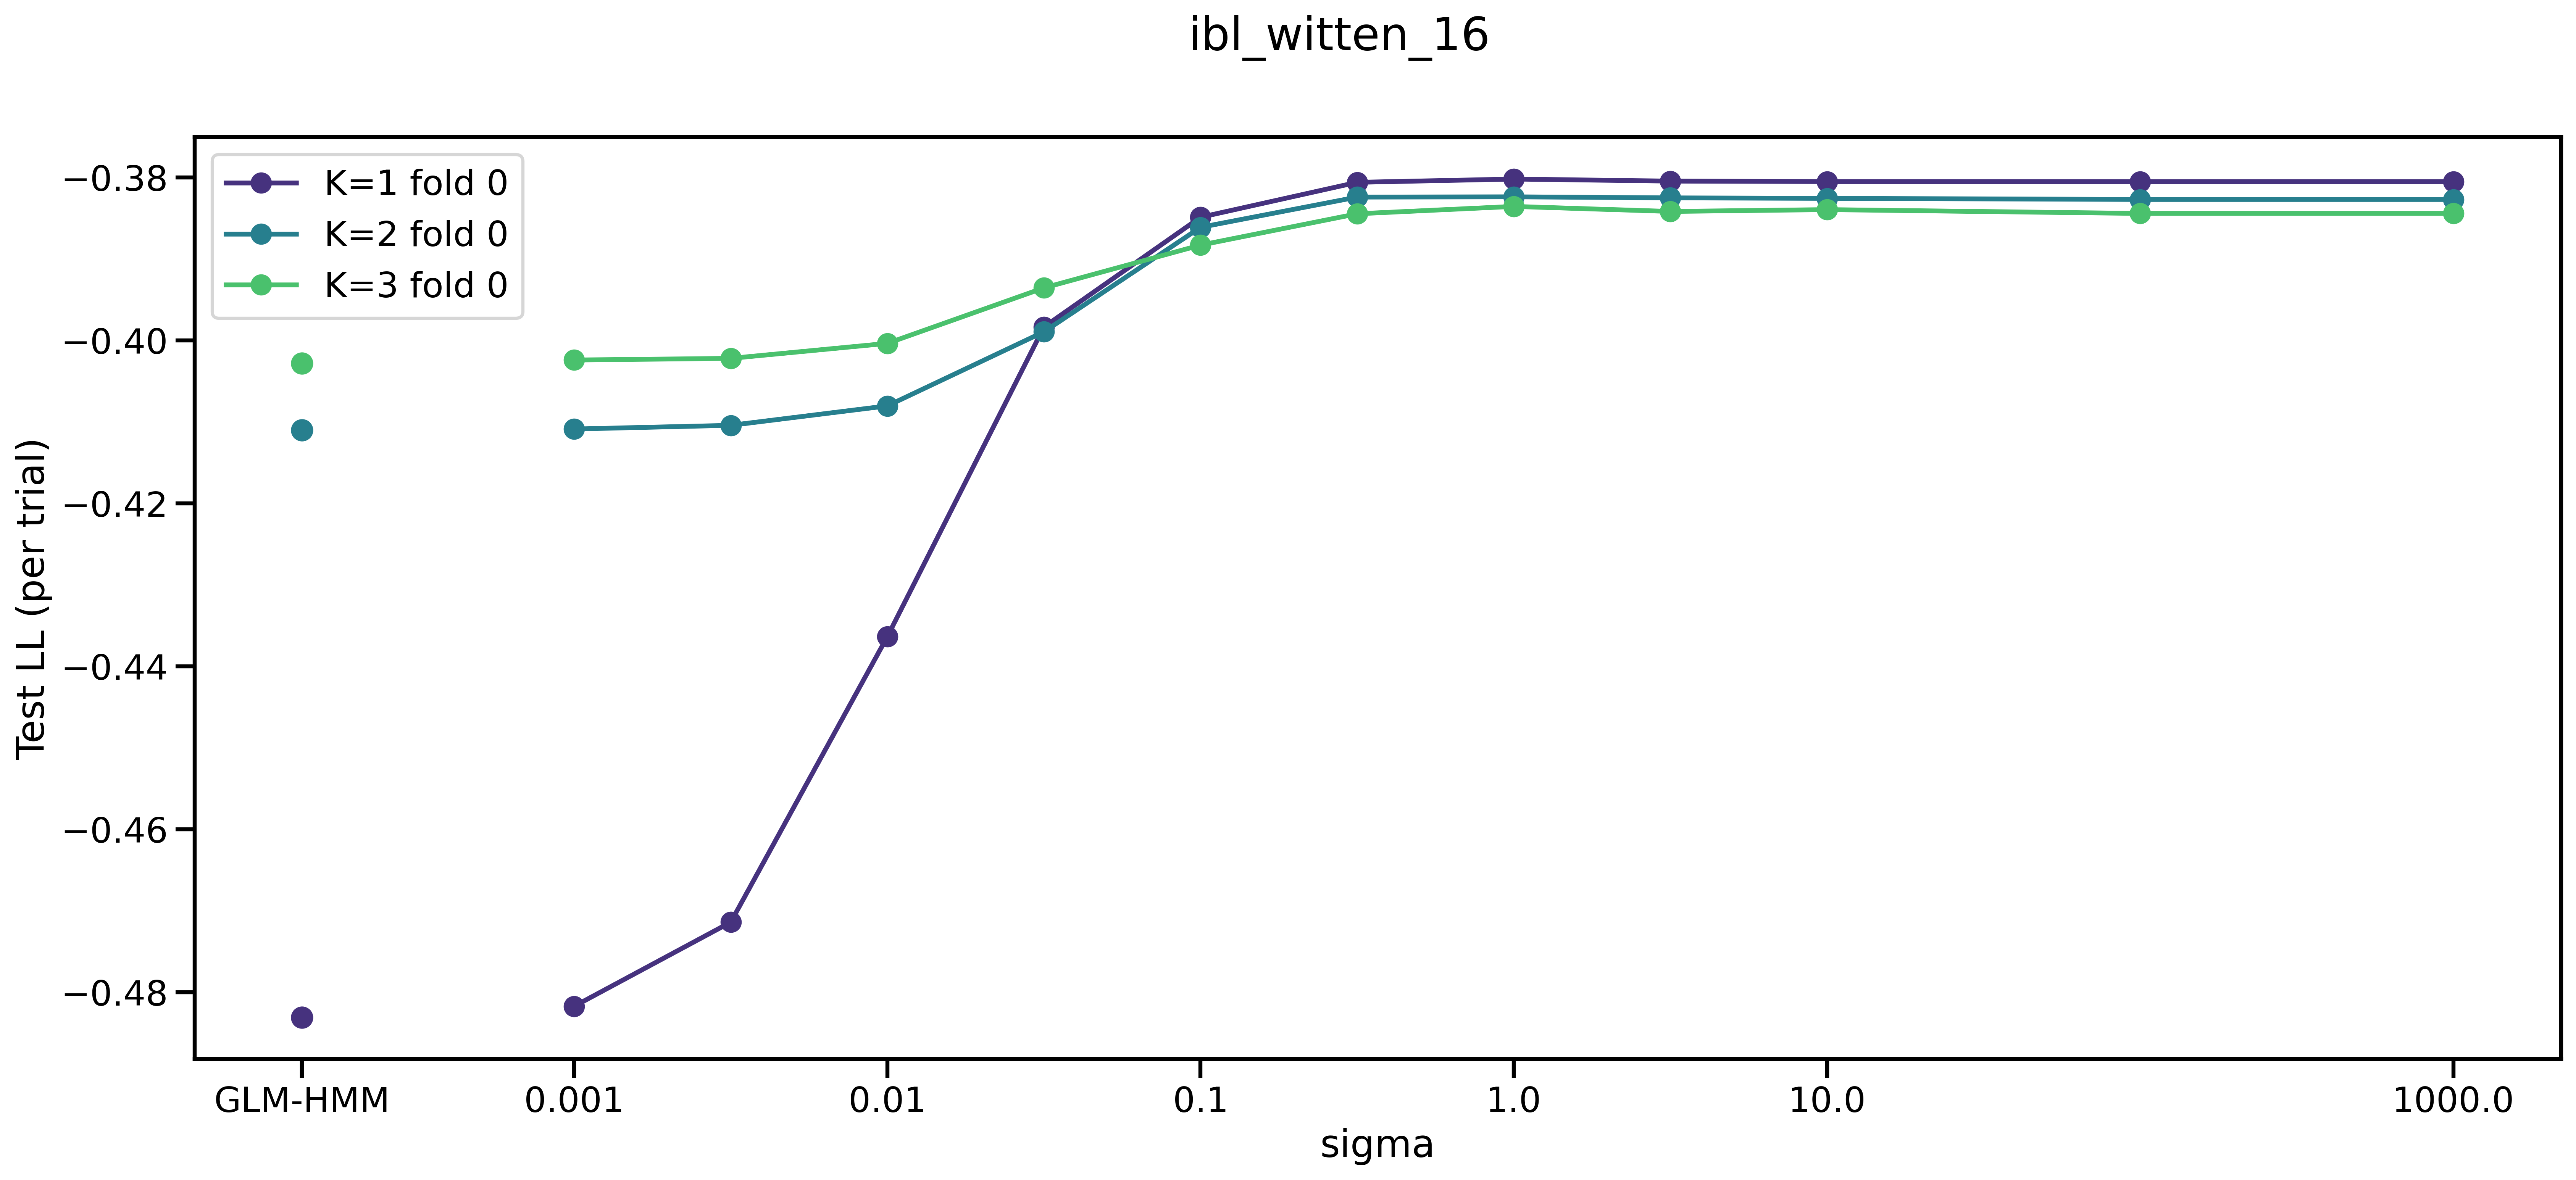

In [80]:
ls = ['-o','-s']
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject}')
for K in range(1,4):
    for fold in range(0, fitFolds):
        plot_testLl_CV_sigma(testLl[fitFolds*(K-1)+fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=2*(K-1), axes=axes, linestyle=ls[fold])

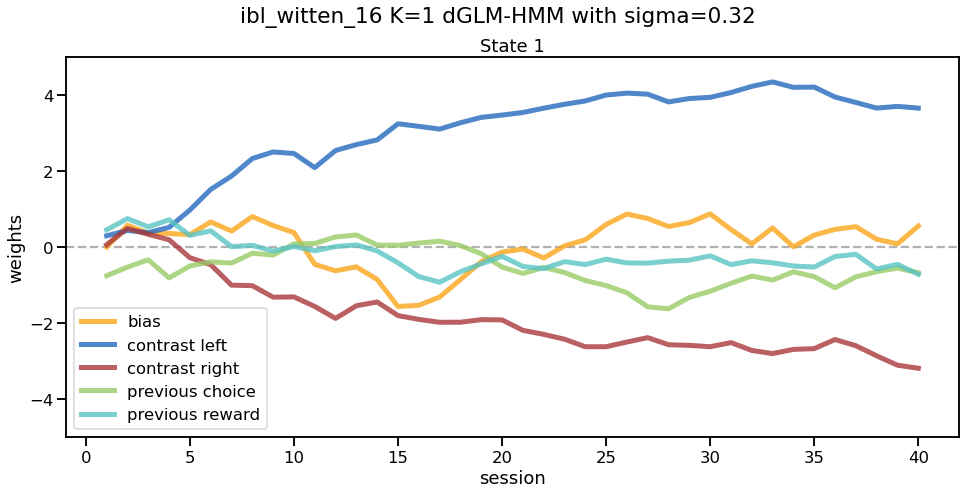

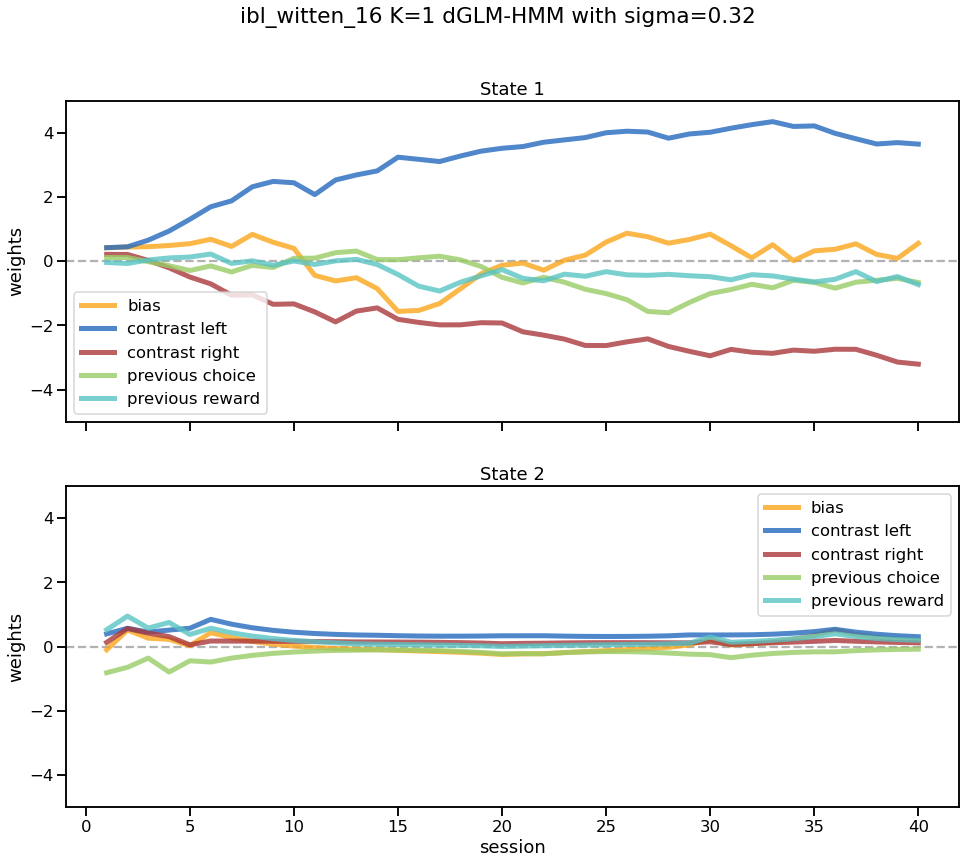

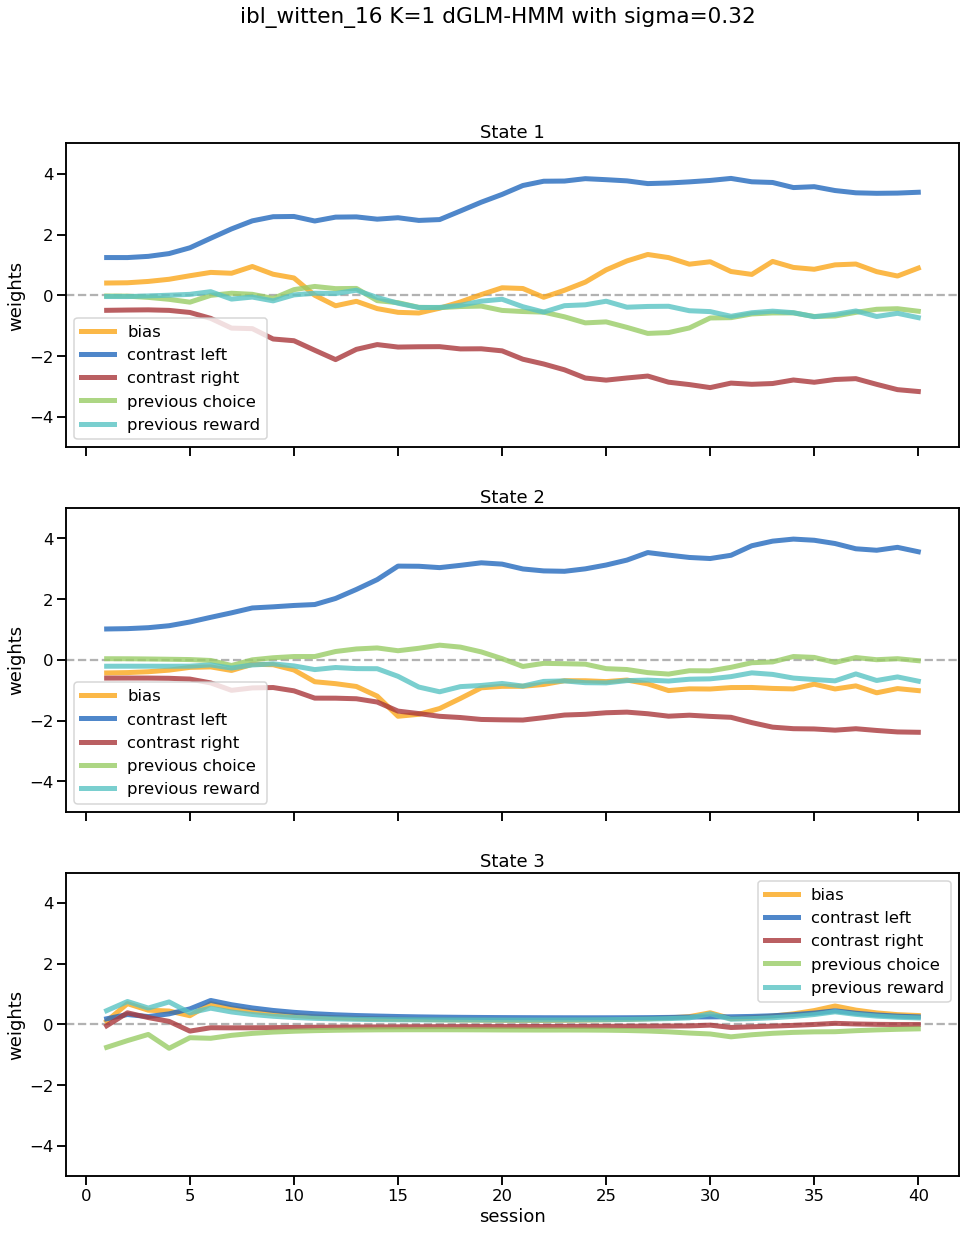

In [82]:
ind = 6
for K in range(1,4):
    for fold in [0]:#range(0, fitFolds):
        fig, axes = plt.subplots(K, 1,figsize=(16,6*K+1), sharex=True)
        fig.suptitle(f'{subject} K=1 dGLM-HMM with sigma={np.round(sigmaList[ind],2)}')
        # fig.tight_layout()
        plotting_weights_IBL(allW[fitFolds*(K-1)+fold][ind], trainSessInd[fitFolds*(K-1)+fold], axes, yLim=[-5,5], colors=myColors, labels=myFeatures)

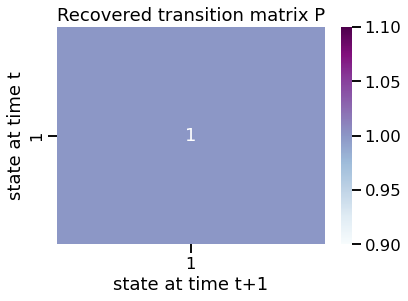

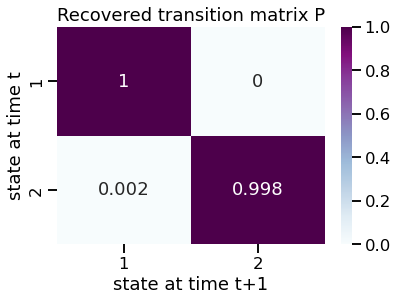

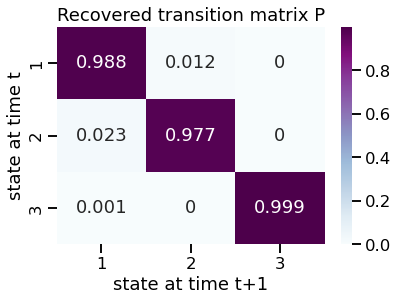

In [83]:
ind = 6
for K in range(1,4):
    for fold in [0]:#range(0, fitFolds):
        fig, axes = plt.subplots()
        sortedStateInd = get_states_order(allW[fitFolds*(K-1)+fold][ind], trainSessInd[0])
        plot_transition_matrix(allP[fitFolds*(K-1)+fold][ind], sortedStateInd)

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/analysis_utils.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts


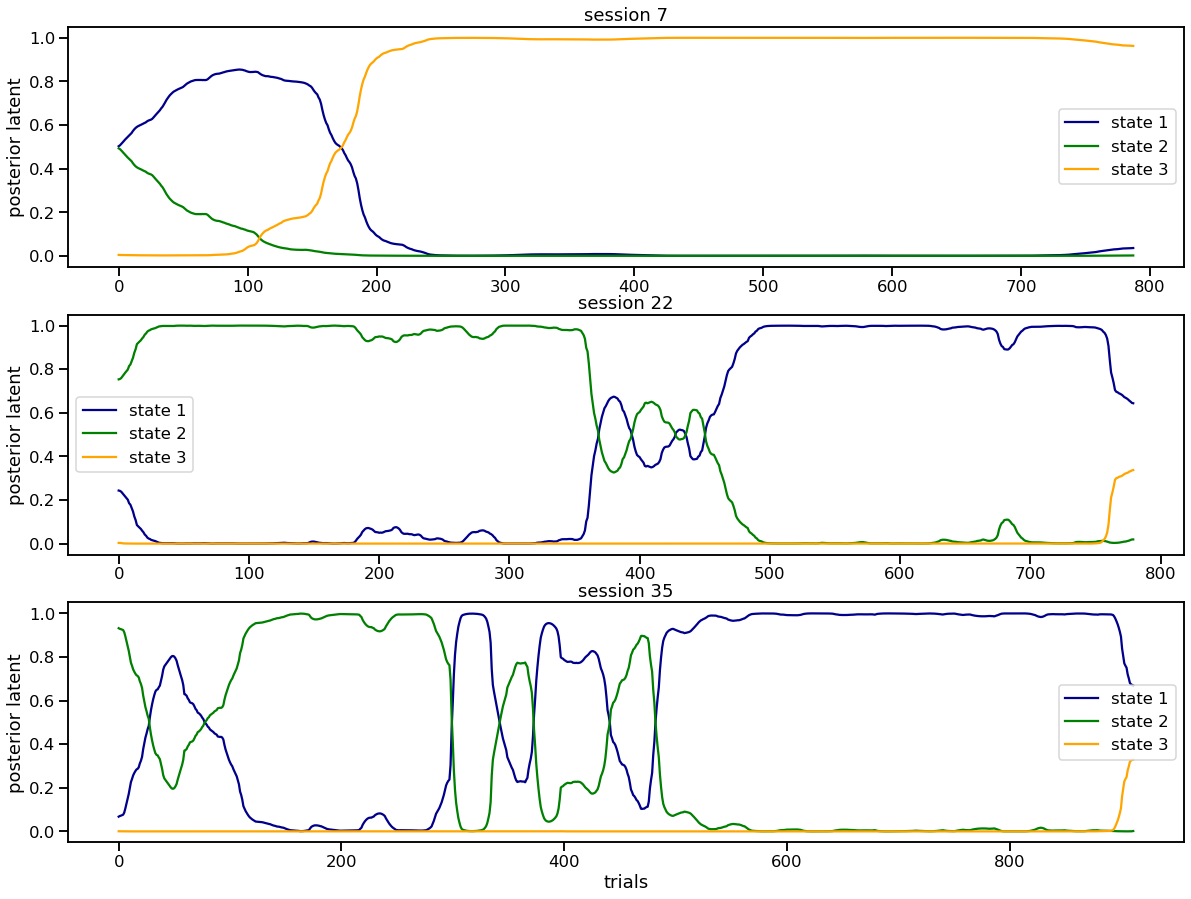

In [78]:
ind = 6
K = 3
fold = 0

sessStop = 40
x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=splitFolds, blocks=10, random_state=1)
N = trainX[fold].shape[0]
D = trainX[fold].shape[1]
C = 2


dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
gamma = dGLM_HMM.get_posterior_latent(allP[fitFolds*(K-1)+fold][ind], allW[fitFolds*(K-1)+fold][ind], trainX[fold], trainY[fold], trainSessInd[fold], pi0=None)

plot_posteior_latent(gamma, trainSessInd[0], sessions = [7,22,35])

In [21]:
# Reading models for following hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2
D = 5

# to tweak for different models:
sessStop = 40 # sessStop in [40,-1]
subject = 'ibl_witten_15' # subject in ['ibl_witten_15','ibl_witten_16']

avgTestLl = []
allP = [] 
allW = [] 
trainSessInd = []
for K in range(1,4):
    testLl = []
    for fold in range(0, fitFolds):
        testLl.append(np.load(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    avgTestLl.append(np.mean(testLl[:],axis=0))

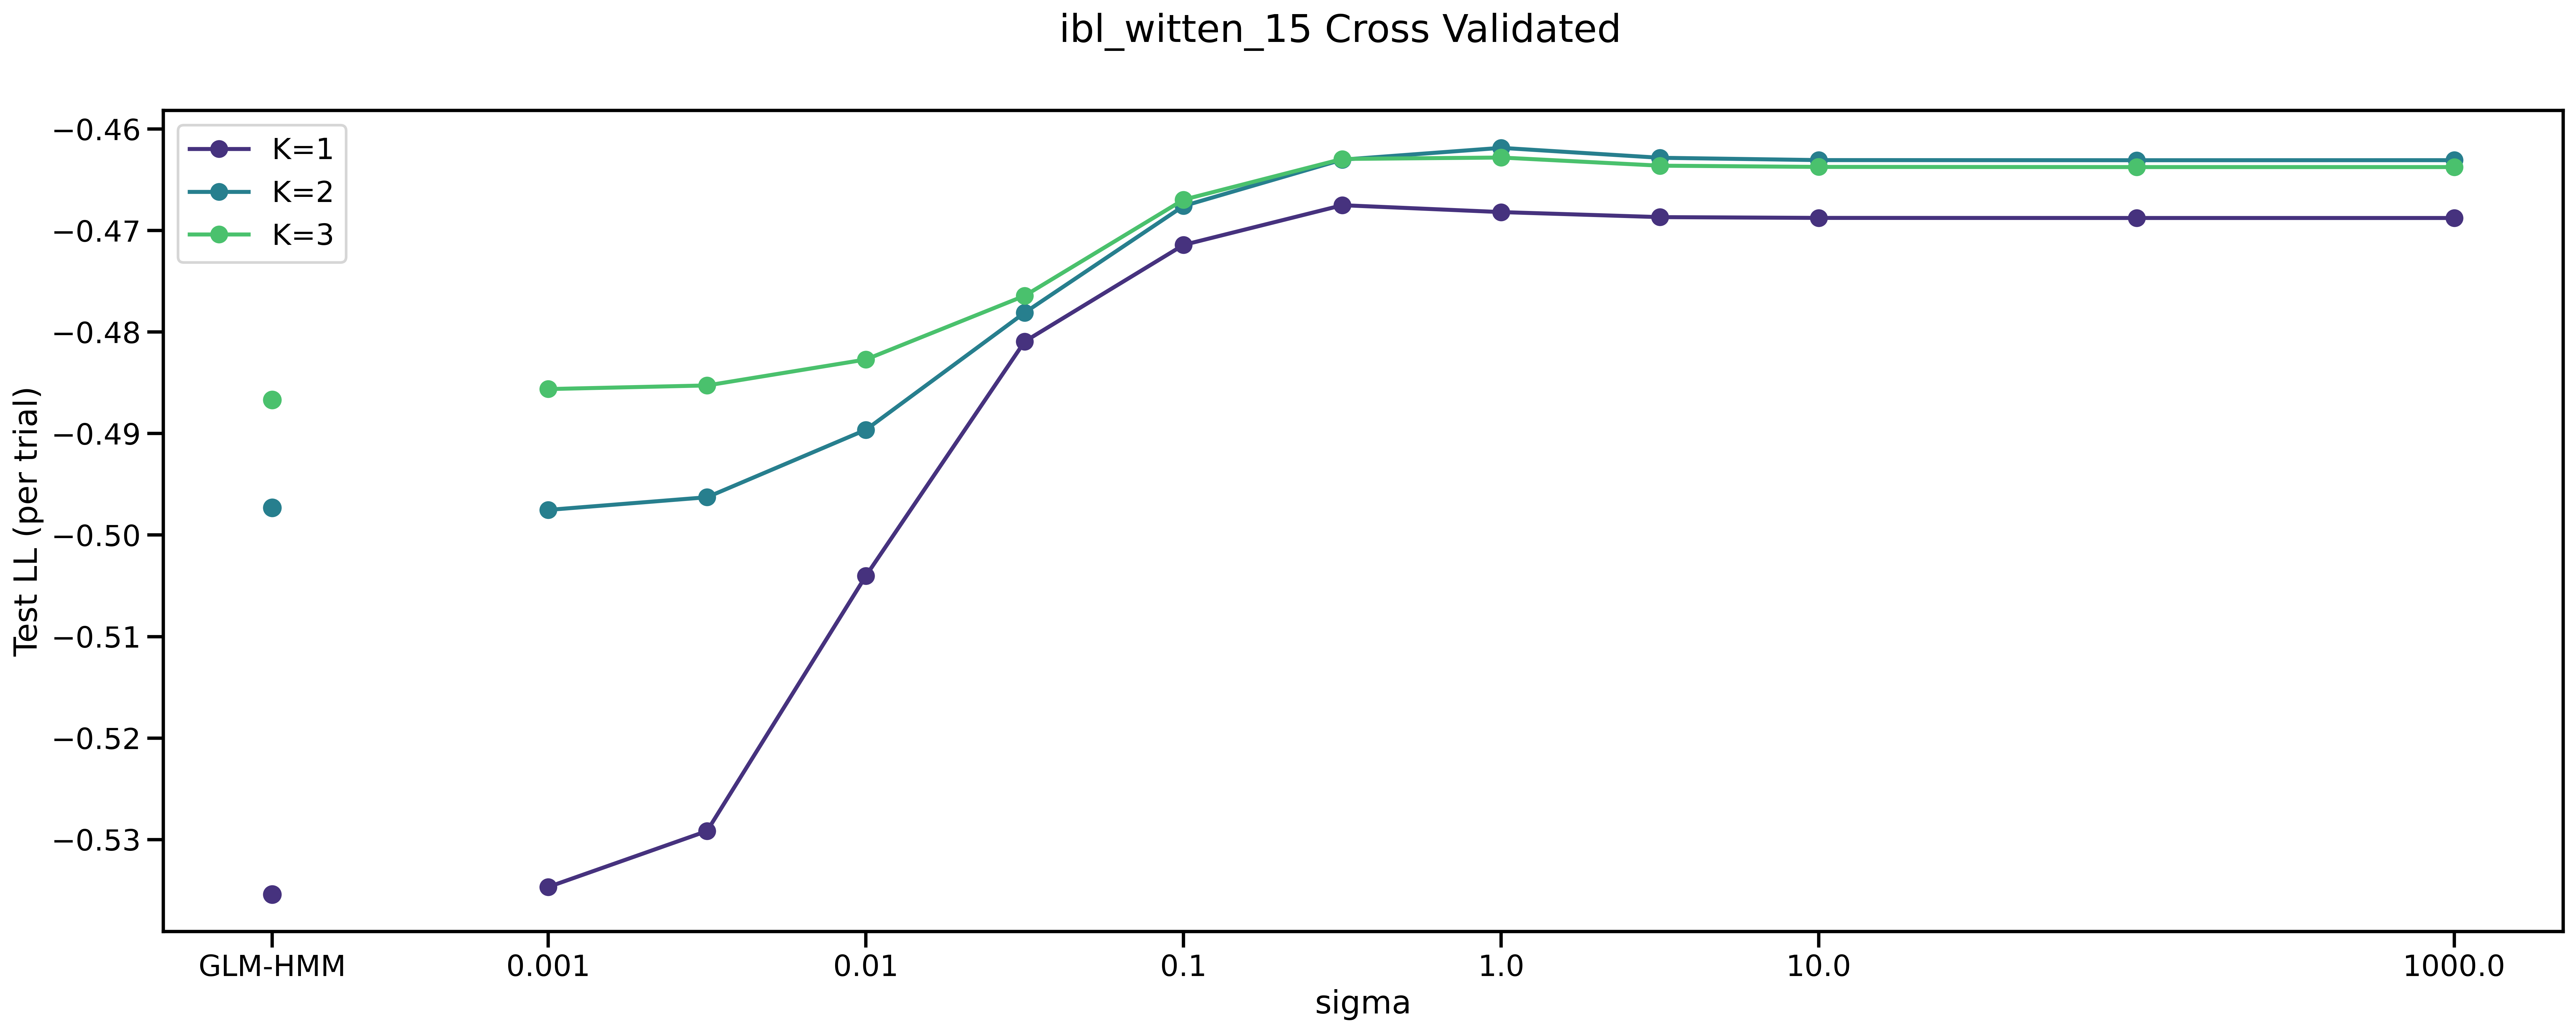

In [22]:
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject} Cross Validated')
fig.tight_layout()
for K in range(1,4):
    plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=2*(K-1), axes=axes)